## 02-02 Transforms

In [1]:
%matplotlib inline
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

torch.manual_seed(0)
torch.__version__

'1.3.0'

### 1.设定文件路径并构建Dataset

设置训练文件路径

In [2]:
rmb_data_path = Path('/media/bnu/file/datasets/pytorch-tutorials/rmb_data')
train_path = rmb_data_path / 'split_data' / 'train'
print(train_path)

/media/bnu/file/datasets/pytorch-tutorials/rmb_data/split_data/train


定义人民币数据的Dataset

In [3]:
class RMBDataset(Dataset):
    
    def __init__(self, image_path, transform=None):
        self.label_dict = {'1': 0, '100': 1}
        self.transform = transform

        self.image_data = []
        for root, dirs, files in os.walk(image_path):
            for sub_dir in dirs:
                # 获取目录下所有图片列表
                image_file_list = os.listdir(image_path / sub_dir)
                image_file_list = list(filter(lambda x: x.endswith('.jpg'), image_file_list))

                # 保存每个图片的路径和标签
                for i in range(len(image_file_list)):
                    image_name = image_file_list[i]
                    file_path = image_path / sub_dir / image_name
                    label = self.label_dict[sub_dir]
                    self.image_data.append((file_path, label))

    def __getitem__(self, index):
        file_path, label = self.image_data[index]
        image = Image.open(file_path).convert('RGB')  # 数据范围0-255
        
        # 对图片进行transform
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

    def __len__(self):
        return len(self.image_data)

temp_dataset = RMBDataset(train_path)
temp_dataset[0]

(<PIL.Image.Image image mode=RGB size=1161x600 at 0x7F79232A3D10>, 1)

### 2.定义Transform反操作转换为图片

In [4]:
def inverse_transform(img_tensor, img_transform):
    # 对标准化进行反向操作
    if 'Normalize' in str(img_transform):
        norm_transform = list(filter(lambda x: isinstance(x, transforms.Normalize), img_transform.transforms))
        mean_tensor = torch.tensor(norm_transform[0].mean, dtype=img_tensor.dtype, device=img_tensor.device)
        std_tensor = torch.tensor(norm_transform[0].std, dtype=img_tensor.dtype, device=img_tensor.device)
        img_tensor.mul_(std_tensor[:, None, None]).add_(mean_tensor[:, None, None])
    
    # C*H*W -> H*W*C
    img_tensor = img_tensor.transpose(0, 2).transpose(0, 1)
    # 将tensor转换为0-255的ndarray
    img_array = np.array(img_tensor) * 255

    return Image.fromarray(img_array.astype('uint8')).convert('RGB')


### 3.查看各个类型的Transform

定义画图函数

In [25]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

def show_image(input_transform, input_lambda=None):
    if input_lambda is None:
        temp_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            input_transform,
            transforms.ToTensor(),
            transforms.Normalize(norm_mean, norm_std)
        ])

        temp_dataset = RMBDataset(train_path, temp_transform)        
        img_tensor = temp_dataset[0][0]
        img = inverse_transform(img_tensor, temp_transform)
        plt.imshow(img)
        plt.show()

    else:
        temp_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            input_transform,
            input_lambda,
        ])

        temp_dataset = RMBDataset(train_path, temp_transform)        
        for i in range(temp_dataset[0][0].shape[0]):
            img_tensor = temp_dataset[0][0][i]
            img = inverse_transform(img_tensor, temp_transform)
            plt.imshow(img)
            plt.show()

中心裁减CenterCrop

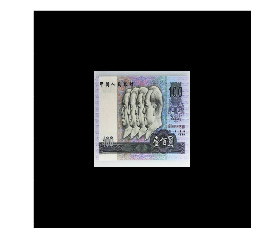

In [26]:
show_image(transforms.CenterCrop(512))

随机裁减RandomCrop

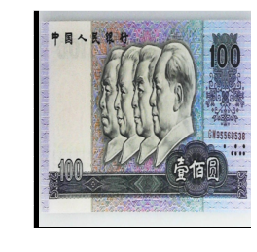

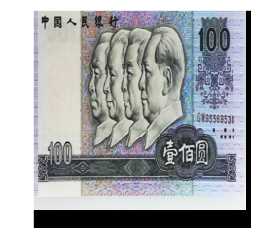

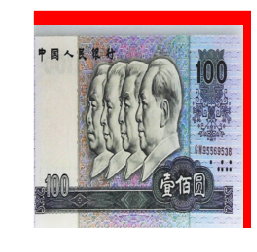

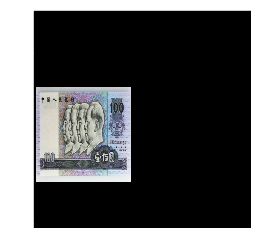

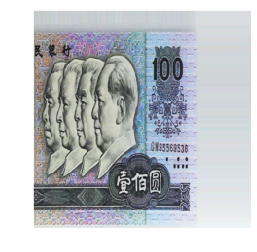

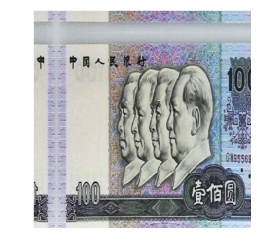

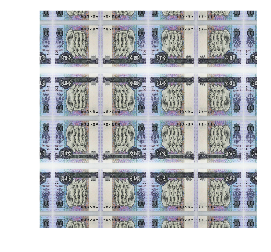

In [27]:
show_image(transforms.RandomCrop(224, padding=16))
show_image(transforms.RandomCrop(224, padding=(16, 64)))
show_image(transforms.RandomCrop(224, padding=16, fill=(255, 0, 0)))
show_image(transforms.RandomCrop(512, pad_if_needed=True))
show_image(transforms.RandomCrop(224, padding=64, padding_mode='edge'))
show_image(transforms.RandomCrop(224, padding=64, padding_mode='reflect'))
show_image(transforms.RandomCrop(1024, padding=1024, padding_mode='symmetric'))

随机大小、长宽比裁减RandomResizedCrop

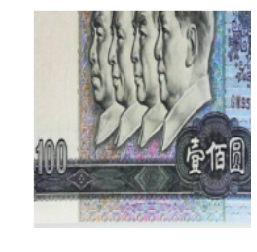

In [28]:
show_image(transforms.RandomResizedCrop(size=224, scale=(0.5, 0.5)))

对4个边角和中心进行裁减

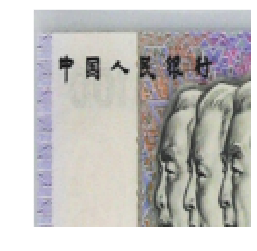

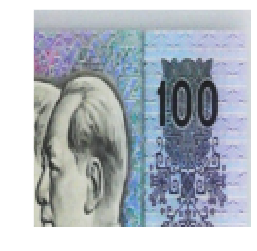

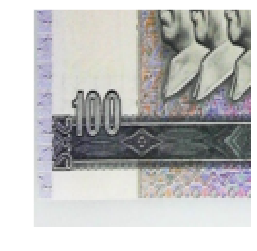

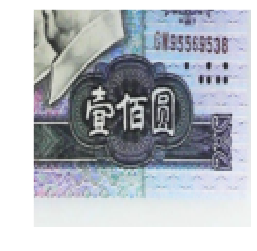

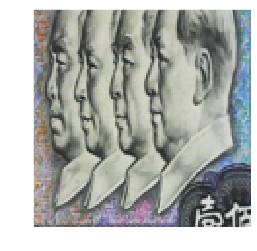

In [29]:
show_image(
    transforms.FiveCrop(112), 
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops]))
)

以FiveCrop为基础进行翻转TenCrop

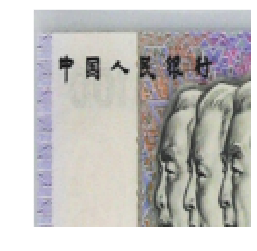

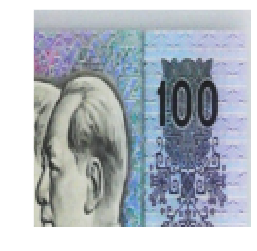

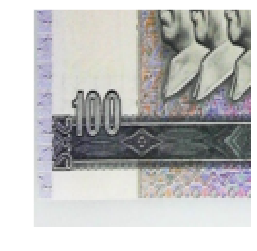

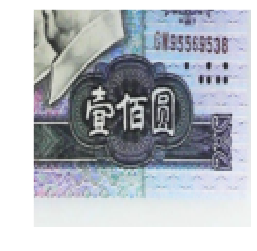

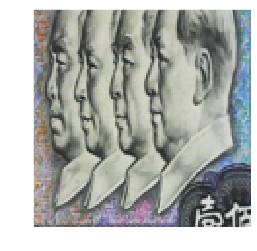

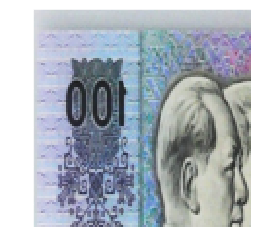

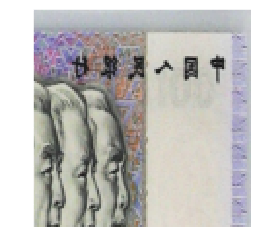

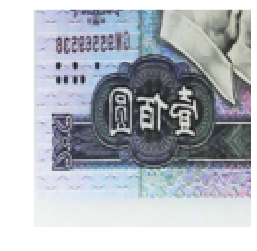

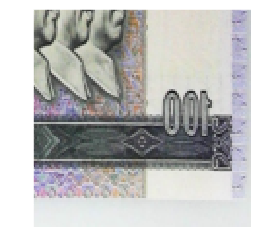

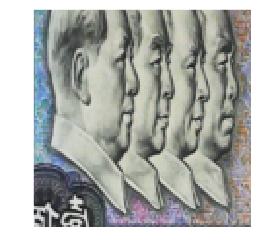

In [32]:
show_image(
    transforms.TenCrop(112, vertical_flip=False), 
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops]))
)

随机水平翻转RandomHorizontalFlip

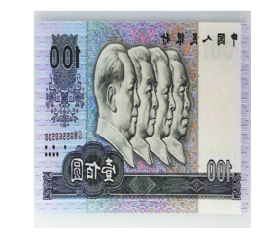

In [33]:
show_image(transforms.RandomHorizontalFlip(p=1))

随机垂直翻转RandomVerticalFlip

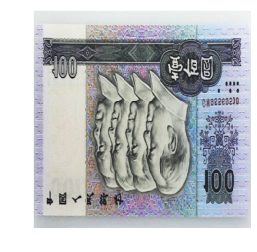

In [35]:
show_image(transforms.RandomVerticalFlip(p=0.5))

随机旋转RandomRotation

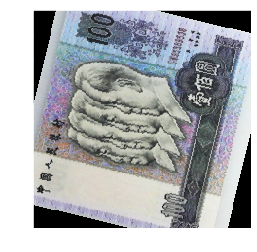

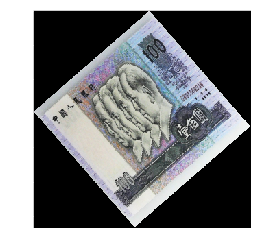

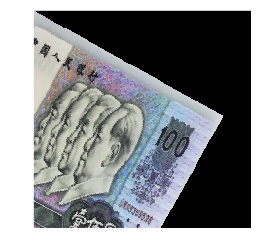

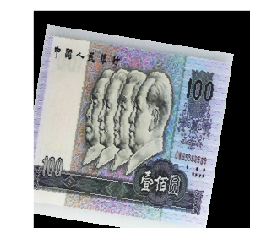

In [41]:
show_image(transforms.RandomRotation(90))
show_image(transforms.RandomRotation(90, expand=True))
show_image(transforms.RandomRotation(30, center=(0, 0)))
show_image(transforms.RandomRotation(30, center=(0, 0), expand=True))